In [1]:
import numpy as np
import matplotlib.pyplot as plt

class EpsilonGreedyBandit:
    def __init__(self, k_arms, epsilon=0.1):
        """
        Initialize the epsilon-greedy bandit algorithm.

        k_arms: number of arms (actions) available
        epsilon: probability of taking a random action (exploration rate)
        """
        self.k = k_arms
        self.epsilon = epsilon

        # Estimated action values (Q-values)
        # We start with optimistic initial values of 0
        self.Q = np.zeros(k_arms)

        # Count how many times each action has been selected
        # This is crucial for updating our estimates
        self.N = np.zeros(k_arms)

        # Keep track of total reward and time steps for analysis
        self.total_reward = 0
        self.time_step = 0

    def select_action(self):
        """
        Select an action using epsilon-greedy strategy.

        Returns: the index of the selected action
        """
        if np.random.random() < self.epsilon:
            # Exploration: choose a random action
            # This ensures we keep learning about all actions
            return np.random.randint(self.k)
        else:
            # Exploitation: choose the action with highest estimated value
            # If there are ties, numpy.argmax picks the first occurrence
            return np.argmax(self.Q)

    def update(self, action, reward):
        """
        Update our estimate for the chosen action based on the received reward.

        action: the action that was taken
        reward: the reward received from that action
        """
        # Increment the count for this action
        self.N[action] += 1

        # Update the action value estimate using incremental average
        # This formula: Q_new = Q_old + (1/N) * (reward - Q_old)
        # is equivalent to calculating the sample average, but more efficient
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

        # Track total performance
        self.total_reward += reward
        self.time_step += 1

    def get_average_reward(self):
        """Return the average reward per time step."""
        return self.total_reward / self.time_step if self.time_step > 0 else 0




In [2]:
class BanditEnvironment:
    """
    Simulates a multi-armed bandit environment with k arms.
    Each arm has a different true expected reward.
    """
    def __init__(self, k_arms, true_values=None):
        self.k = k_arms

        # If true values aren't provided, generate them randomly
        # We use a normal distribution centered around 0
        if true_values is None:
            self.true_values = np.random.normal(0, 1, k_arms)
        else:
            self.true_values = true_values

        # The optimal action is the one with highest true value
        self.optimal_action = np.argmax(self.true_values)

    def pull_arm(self, action):
        """
        Pull an arm and receive a reward.
        Rewards are normally distributed around the true value of each arm.
        """
        # Add some noise to the true value to simulate real-world uncertainty
        reward = np.random.normal(self.true_values[action], 1)
        return reward

    def get_optimal_value(self):
        """Return the expected reward of the optimal action."""
        return self.true_values[self.optimal_action]




In [3]:
def run_experiment(k_arms=10, epsilon=0.1, time_steps=1000):
    """
    Run a complete experiment to demonstrate how epsilon-greedy learns.
    """
    # Create the environment and the agent
    env = BanditEnvironment(k_arms)
    agent = EpsilonGreedyBandit(k_arms, epsilon)

    # Track performance over time
    rewards = []
    regrets = []

    print(f"True action values: {env.true_values}")
    print(f"Optimal action: {env.optimal_action} (value: {env.get_optimal_value():.3f})")
    print(f"Running {time_steps} steps with epsilon = {epsilon}...")
    print()

    for t in range(time_steps):
        # Agent selects an action
        action = agent.select_action()

        # Environment provides reward
        reward = env.pull_arm(action)

        # Agent learns from the experience
        agent.update(action, reward)

        # Calculate instantaneous regret
        optimal_reward = env.get_optimal_value()
        regret = optimal_reward - reward

        # Store for analysis
        rewards.append(reward)
        regrets.append(regret)

        # Print progress occasionally
        if (t + 1) % 200 == 0:
            avg_reward = np.mean(rewards[-200:])  # Average over last 200 steps
            print(f"Step {t+1}: Recent average reward = {avg_reward:.3f}")

    # Final analysis
    print(f"\nFinal Results:")
    print(f"Learned action values: {agent.Q}")
    print(f"Action selection counts: {agent.N}")
    print(f"Total regret: {sum(regrets):.3f}")
    print(f"Average regret per step: {np.mean(regrets):.3f}")

    # Visualize the learning process
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(np.cumsum(regrets))
    plt.title('Cumulative Regret Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Regret')

    plt.subplot(1, 2, 2)
    window_size = 50
    smoothed_rewards = [np.mean(rewards[max(0, i-window_size):i+1])
                       for i in range(len(rewards))]
    plt.plot(smoothed_rewards)
    plt.axhline(y=env.get_optimal_value(), color='r', linestyle='--',
                label='Optimal Expected Reward')
    plt.title('Average Reward Over Time (50-step moving average)')
    plt.xlabel('Time Step')
    plt.ylabel('Average Reward')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return agent, env



=== Epsilon-Greedy Bandit Demonstration ===

True action values: [-1.82840186  0.5737315  -0.0123538   0.35435196 -1.03727042 -0.0282088
 -0.1389137  -0.71375098  0.18558543  0.77234458]
Optimal action: 9 (value: 0.772)
Running 1000 steps with epsilon = 0.1...

Step 200: Recent average reward = 0.487
Step 400: Recent average reward = 0.487
Step 600: Recent average reward = 0.494
Step 800: Recent average reward = 0.365
Step 1000: Recent average reward = 0.464

Final Results:
Learned action values: [-2.19777458  0.53065503  0.39194066  0.37082384 -0.88360713 -0.00752198
 -0.37511579 -0.86833476  0.25263734  0.50222281]
Action selection counts: [  8. 869.  16.  19.   5.  15.   9.  11.  17.  31.]
Total regret: 313.066
Average regret per step: 0.313


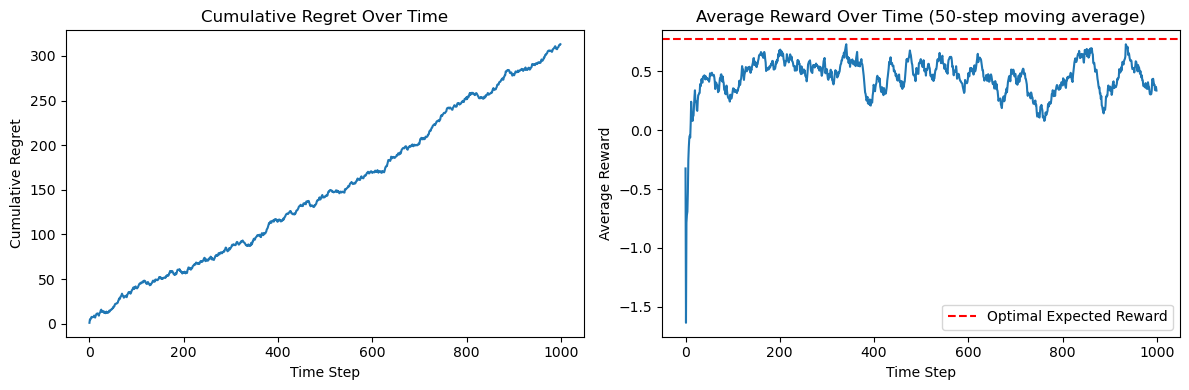


Try running this with different epsilon values:
- epsilon=0.0 (pure exploitation)
- epsilon=0.3 (more exploration)
- epsilon=1.0 (pure exploration)
What do you think will happen in each case?


In [4]:
# Try different epsilon values to see the effect
print("=== Epsilon-Greedy Bandit Demonstration ===\n")

agent, env = run_experiment(k_arms=10, epsilon=0.1, time_steps=1000)

print("\n" + "="*50)
print("Try running this with different epsilon values:")
print("- epsilon=0.0 (pure exploitation)")
print("- epsilon=0.3 (more exploration)")
print("- epsilon=1.0 (pure exploration)")
print("What do you think will happen in each case?")

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class UCBBandit:
    def __init__(self, k_arms, c=2.0):
        """
        Initialize the UCB (Upper Confidence Bounds) bandit algorithm.

        k_arms: number of arms (actions) available
        c: confidence parameter that controls the degree of exploration
           Higher c means more exploration, lower c means more exploitation
        """
        self.k = k_arms
        self.c = c

        # Estimated action values (Q-values)
        self.Q = np.zeros(k_arms)

        # Count how many times each action has been selected
        self.N = np.zeros(k_arms)

        # Total time steps taken (needed for the UCB formula)
        self.t = 0

        # Keep track of total reward for analysis
        self.total_reward = 0

    def select_action(self):
        """
        Select an action using the UCB strategy.

        The key insight: choose the action that maximizes
        Q(action) + c * sqrt(ln(t) / N(action))

        This balances exploitation (Q values) with exploration (uncertainty bonus)
        """
        self.t += 1

        # Handle the special case where some actions haven't been tried yet
        # We must try each action at least once before UCB makes sense
        for action in range(self.k):
            if self.N[action] == 0:
                return action

        # Calculate UCB values for all actions
        ucb_values = np.zeros(self.k)
        for action in range(self.k):
            # The confidence interval grows with uncertainty (small N[action])
            # and shrinks slowly over time due to the logarithmic growth
            confidence_bonus = self.c * np.sqrt(np.log(self.t) / self.N[action])
            ucb_values[action] = self.Q[action] + confidence_bonus

        # Choose the action with the highest UCB value
        return np.argmax(ucb_values)

    def update(self, action, reward):
        """
        Update our estimate for the chosen action based on the received reward.
        This is identical to epsilon-greedy - only the selection strategy differs.
        """
        # Increment the count for this action
        self.N[action] += 1

        # Update the action value estimate using incremental average
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

        # Track total performance
        self.total_reward += reward

    def get_average_reward(self):
        """Return the average reward per time step."""
        return self.total_reward / self.t if self.t > 0 else 0

    def get_ucb_values(self):
        """
        Get current UCB values for analysis.
        Useful for understanding what the algorithm is thinking.
        """
        if self.t == 0:
            return np.zeros(self.k)

        ucb_values = np.zeros(self.k)
        for action in range(self.k):
            if self.N[action] == 0:
                ucb_values[action] = np.inf  # Untried actions have infinite UCB
            else:
                confidence_bonus = self.c * np.sqrt(np.log(self.t) / self.N[action])
                ucb_values[action] = self.Q[action] + confidence_bonus

        return ucb_values


def compare_algorithms(k_arms=10, time_steps=1000, runs=100):
    """
    Compare epsilon-greedy and UCB algorithms over multiple runs.
    This helps us understand their relative strengths and weaknesses.
    """
    # We'll test multiple configurations
    algorithms = [
        ("Epsilon-Greedy (ε=0.01)", lambda: EpsilonGreedyBandit(k_arms, 0.01)),
        ("Epsilon-Greedy (ε=0.1)", lambda: EpsilonGreedyBandit(k_arms, 0.1)),
        ("UCB (c=1)", lambda: UCBBandit(k_arms, 1.0)),
        ("UCB (c=2)", lambda: UCBBandit(k_arms, 2.0)),
    ]

    results = {}

    for name, create_agent in algorithms:
        print(f"Testing {name}...")

        all_regrets = []
        all_rewards = []

        for run in range(runs):
            # Create fresh environment and agent for each run
            env = BanditEnvironment(k_arms)
            agent = create_agent()

            run_regrets = []
            run_rewards = []

            for t in range(time_steps):
                action = agent.select_action()
                reward = env.pull_arm(action)
                agent.update(action, reward)

                # Calculate regret for this step
                optimal_reward = env.get_optimal_value()
                regret = optimal_reward - reward

                run_regrets.append(regret)
                run_rewards.append(reward)

            all_regrets.append(run_regrets)
            all_rewards.append(run_rewards)

        # Average across all runs
        avg_regrets = np.mean(all_regrets, axis=0)
        avg_rewards = np.mean(all_rewards, axis=0)

        results[name] = {
            'regrets': avg_regrets,
            'rewards': avg_rewards,
            'total_regret': np.sum(avg_regrets)
        }

    # Plot comparison
    plt.figure(figsize=(15, 5))

    # Cumulative regret comparison
    plt.subplot(1, 3, 1)
    for name, data in results.items():
        plt.plot(np.cumsum(data['regrets']), label=name)
    plt.title('Cumulative Regret Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Regret')
    plt.legend()

    # Average reward comparison
    plt.subplot(1, 3, 2)
    for name, data in results.items():
        # Use moving average for smoother visualization
        window_size = 50
        smoothed = [np.mean(data['rewards'][max(0, i-window_size):i+1])
                   for i in range(len(data['rewards']))]
        plt.plot(smoothed, label=name)
    plt.title('Average Reward Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Average Reward')
    plt.legend()

    # Final performance comparison
    plt.subplot(1, 3, 3)
    names = list(results.keys())
    total_regrets = [results[name]['total_regret'] for name in names]
    plt.bar(range(len(names)), total_regrets)
    plt.xticks(range(len(names)), [name.split('(')[0] for name in names], rotation=45)
    plt.title('Total Regret (Lower is Better)')
    plt.ylabel('Total Regret')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nFinal Results Summary:")
    print("-" * 50)
    for name, data in results.items():
        print(f"{name}: Total Regret = {data['total_regret']:.2f}")

    return results


=== UCB vs Epsilon-Greedy Comparison ===

Testing Epsilon-Greedy (ε=0.01)...
Testing Epsilon-Greedy (ε=0.1)...
Testing UCB (c=1)...
Testing UCB (c=2)...


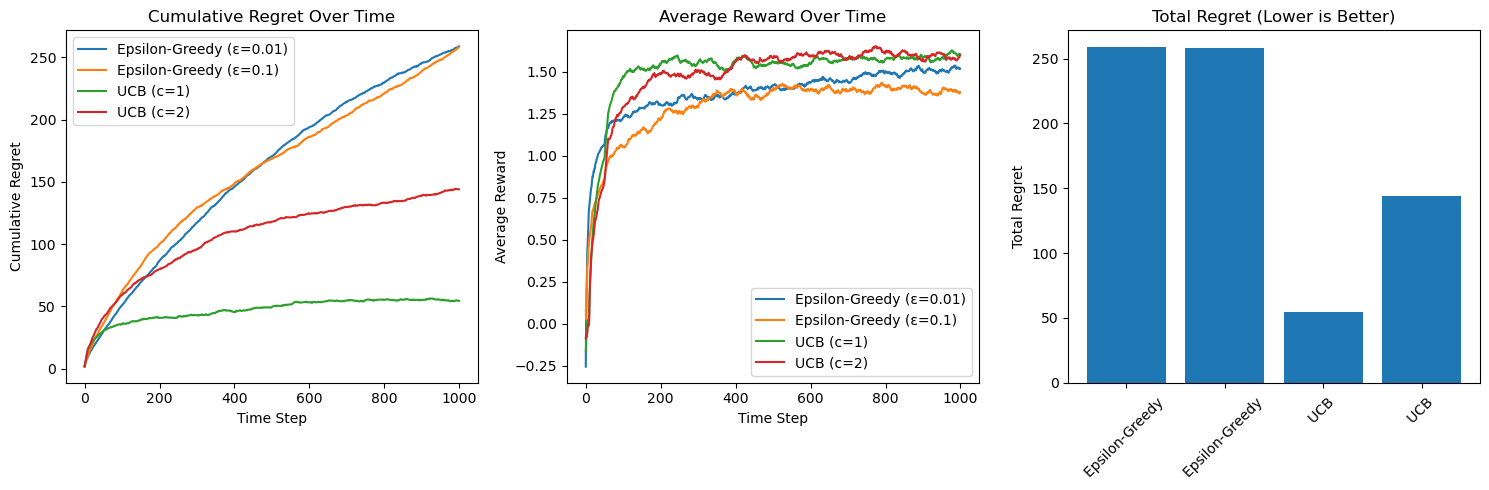


Final Results Summary:
--------------------------------------------------
Epsilon-Greedy (ε=0.01): Total Regret = 258.84
Epsilon-Greedy (ε=0.1): Total Regret = 258.13
UCB (c=1): Total Regret = 54.33
UCB (c=2): Total Regret = 143.96

Key Insights:
1. UCB typically achieves lower regret than epsilon-greedy
2. UCB's performance is less sensitive to parameter tuning
3. Both algorithms eventually converge, but UCB often learns faster


In [6]:
print("=== UCB vs Epsilon-Greedy Comparison ===\n")

# Run the comparison
results = compare_algorithms(k_arms=10, time_steps=1000, runs=50)

print("\nKey Insights:")
print("1. UCB typically achieves lower regret than epsilon-greedy")
print("2. UCB's performance is less sensitive to parameter tuning")
print("3. Both algorithms eventually converge, but UCB often learns faster")